In [46]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
from sqlalchemy import create_engine
from mpl_toolkits import mplot3d
from surprise import Reader, Dataset, SVD, accuracy, KNNBasic, BaselineOnly, NormalPredictor, KNNWithMeans, SVDpp, Trainset
from surprise.model_selection import cross_validate, train_test_split, KFold
from surprise.accuracy import rmse, mae, mse
from surprise.similarities import cosine
from surprise.prediction_algorithms.predictions import Prediction

### Configuracion de tablas

In [2]:
pd.options.display.max_rows = 112
pd.options.display.min_rows = 25
pd.set_option('display.max_columns', None)

### Leer los datos

In [5]:
SERVER = 'DESKTOP-4AI1QI3'
DATABASE = 'Itunasam1404'
USER = 'sa'
PASSWORD = '011235813213455'
connection_string = f"mssql+pyodbc://{USER}:{PASSWORD}@{SERVER}/{DATABASE}?driver=ODBC+Driver+17+for+SQL+Server"
con = create_engine(connection_string)

In [6]:
Alumno = pd.read_sql_table('Alumno', con, 'dbo')
Alumno.head()

,Alumno,Password,AlumnoCarne,Sede,ApellidoPaterno,ApellidoMaterno,Nombre,NombreCompleto,Escuela,Curricula,Especialidad,TipoDocumento,Dni,Varon,FechaNacimiento,FechaEgreso,Direccion,Telefono,TelefonoEmergencia,ColegioProcedencia,Universidad,Celular,Email,ModalidadIngreso,PuntajeIngreso,OME,OMG,Trabajador,PaginaWeb,Condicion,CreditosAcumulados,Observaciones,Foto,Activo,pago,razon_desactivado,semestre_reincorporacion,remember_token,matricula_especial,SemestreIngreso,forzar_regular,condicion_regularidad,reconsiderado,tipo_matricula,Ubigeo,renuncio,valido,solicitoCarne,CarnetExtranjeria,id,proceso_ingreso,correo_institucional,pronabec,encuestable,actualizado
0,00.0001.5.AC,false,2000390001,01,CABELLO,CHAVEZ,JULIO CESAR,CABELLO CHAVEZ JULIO CESAR,09,01,None,1,,1,1900-01-01,NaT,,,,102,033,,,A,0.00,0,0,None,,None,0.0,,,False,0,None,None,None,0,None,0,Irregular,0.0,extemporanea,None,0.0,0.0,NaN,None,1,None,None,0,0,0
1,00.0002.N.AC,false,2000390002,01,PADILLA,PALMA,LUIS MIGUEL FORTUNATO,PADILLA PALMA LUIS MIGUEL FORTUNATO,09,04,None,1,40771971,1,1980-12-12,NaT,JR. POMABAMBA 111,396226,944922759,102,033,,LUISMPP00@HOTMAIL.COM,A,0.00,0,0,None,,None,0.0,,,False,0,None,None,None,0,None,0,Irregular,0.0,extemporanea,None,0.0,0.0,NaN,None,2,None,None,0,0,0
2,00.0004.9.AC,false,2000390004,01,SOLIS,VERGARAY,GUSTAVO ADOLFO,SOLIS VERGARAY GUSTAVO ADOLFO,09,04,None,1,,1,1900-01-01,NaT,,,,102,033,,,A,0.00,0,0,None,,None,0.0,,,False,0,None,None,None,0,None,0,Irregular,0.0,extemporanea,None,0.0,0.0,NaN,None,3,None,None,0,0,0
3,00.0005.3.AC,false,2000390005,01,BERROCAL,CABRERA,SADRO ANGEL,BERROCAL CABRERA SADRO ANGEL,09,01,None,1,,1,1900-01-01,NaT,,,,102,033,,,A,0.00,0,0,None,,None,0.0,,,False,0,None,None,None,0,None,0,Irregular,0.0,extemporanea,None,0.0,0.0,NaN,None,4,None,None,0,0,0
4,00.0006.8.AL,false,2000500006,01,GAMARRA,TAHUA,DANIEL,GAMARRA TAHUA DANIEL,16,03,None,1,,1,1900-01-01,NaT,,,,102,033,,,A,0.00,0,0,None,,,0.0,,,False,0,None,None,None,0,None,0,Irregular,0.0,extemporanea,None,0.0,0.0,NaN,None,5,None,None,0,0,0


In [7]:
Curso = pd.read_sql_table('Curso', con, 'dbo')
Curso.drop(['CreditosAprobados','Horario','Sumilla','Tipo','Distancia','codigo','resumen','formato_virtual','prediccion_matriculados','DepartamentoAcademico','DocentePrincipal','DocenteAuxiliar'], axis=1, inplace=True)
Curso.Ciclo, Curso.Curso = Curso.Ciclo.str.strip(), Curso.Curso.str.strip()
Curso.head()

,id,Escuela,Curricula,Curso,Nombre,NumeroCreditos,Mascara,Ciclo,TipoCurso,HorasTeoria,HorasPractica,HorasLaboratorio,General,Control,requiere_laboratorio,requiere_equipo_especializado,cantidad_equipo_especializado,estudiantes_equipo_especializado,nombre_equipo_especializado,requiere_turno_especial,motivo_turno_especial,HorasReales,laboratorio,ingresantes,cuenta_para_cruces,investigacion,unidad_competencia_id,ciudadania,responsabilidad,experienciapre,curso_area_formativa_id,plan_estudios_id,virtual
0,1,07,04,CQ-G01,QUÍMICA GENERAL I,5.0,1,I,O,4.0,3.0,0.0,0.0,1.0,False,False,0.0,0.0,None,False,None,7.0,None,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,07,04,UE-K10,TALLER DE COMUNICACIÓN ORAL Y ESCRITA,2.0,2,I,O,1.0,2.0,0.0,0.0,1.0,False,False,0.0,0.0,None,False,None,3.0,None,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,3,07,04,CB-Q01,BIOLOGÍA GENERAL,4.0,3,I,O,3.0,3.0,0.0,0.0,1.0,False,False,0.0,0.0,None,False,None,6.0,None,0,1,1.0,NaN,NaN,0.0,NaN,NaN,NaN,0
3,4,07,04,CM-A02,MATEMÁTICA I,5.0,4,I,O,4.0,2.0,0.0,0.0,1.0,False,False,0.0,0.0,None,False,None,6.0,None,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,5,07,03,UE-L01,LENGUAJE I,3.0,1,I,O,2.0,2.0,0.0,0.0,NaN,False,False,0.0,0.0,None,False,None,4.0,None,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [8]:
Escuela = pd.read_sql_table('Escuela', con, 'dbo')
Escuela.drop(['FechaCreacion','FechaFuncionamiento','NombreGrado','NombreTituloVaron','NombreTituloDama','ubigeo',
              'ResolucionEscuela','ConsiderarGrados','DispositivoFuncionamiento','DuracionAnios','Creditos',
              'NivelGrado','DuracionSemestres','Descripcion'], axis=1, inplace=True)
Escuela.drop(Escuela[Escuela.Escuela == '33'].index, axis=0, inplace=True)
Escuela.head()

,Escuela,Facultad,Abreviatura,Activo
0,01,02,AGRONOMÍA,True
1,02,04,ING. IND. ALIM.,True
2,03,02,ING. AGRICOLA,True
3,04,01,EST. E INFORMAT,True
4,05,01,LIC. MATEMAT.,True


In [9]:
Curricula = pd.read_sql_table('Curricula', con, 'dbo')
Curricula.drop(['Ciclo'], axis=1, inplace=True)
Curricula.head()

,Escuela,Curricula,Descripcion,CreditosMinimosObligatorios,CreditosMinimosElectivos,SemestreInicio,SemestreFin,Vigente,Activo,antiguo,actualizacion
0,03,01,CURRICULA 1988,200.0,20.0,1988-1,1992-1,0,0,0,0
1,03,02,CURRICULA 1993,240.0,30.0,1993-1,1987-1,0,0,0,0
2,07,03,,200.0,20.0,2005-1,2005-1,0,0,0,0
3,07,04,,216.0,9.0,2005-1,2005-1,0,0,0,0
4,07,01,,200.0,20.0,2005-1,2005-1,0,0,0,0


In [10]:
Semestre = pd.read_sql_table('Semestre', con, 'dbo')
Semestre.drop(['nombre','Activo','vigente','especial','cuenta_veces_desaprobadas','conectado_tesoreria'], axis=1, inplace=True)
Semestre.sort_values('orden', inplace=True)
Semestre.head()

,Semestre,Descripcion,orden,tiene_ingresantes,tipo_id
18,1978-1,,1.0,False,1.0
20,1978-2,SEMESTRE 1978-2,2.0,False,1.0
21,1979-0,SEMESTRE 1979-0,3.0,False,2.0
22,1979-1,SEMESTRE 1979-1,4.0,False,1.0
23,1979-2,SEMESTRE 1979-2,5.0,False,1.0


In [11]:
DepartamentoAcademico = pd.read_sql_table('DepartamentoAcademico', con, 'dbo')
DepartamentoAcademico.head()

,DepartamentoAcademico,Descripcion,Facultad,Escuela,Activo
0,51,AGRONOMIA,02,01,True
1,00,-,03,05,False
2,38,CIENCIAS,01,05,False
3,39,ESTADISTICA Y SISTEMAS,01,04,False
4,40,CIENCIA Y TECNOLOGIA DE ALIMENTOS,04,02,True


In [12]:
Trabajador = pd.read_sql_table('Trabajador', con, 'dbo')
Trabajador.drop(['Telefono','TelefonoEmergencia','Celular','Direccion','PaginaWeb',
                 'Email','FechaIngreso','FechaEgreso','FechaNacimiento','Observaciones',
                 'Dni','Foto','password','PASSMD5','remember_token','categoria_original',
                 'correo_institucional','id','ApellidoPaterno','ApellidoMaterno','Nombre'], axis=1, inplace=True)
Trabajador.Trabajador, Trabajador.Profesion = Trabajador.Trabajador.str.strip(), Trabajador.Profesion.str.strip()
Trabajador.drop_duplicates('Trabajador', inplace=True, keep='last')
Trabajador.head()

,Trabajador,NombreCompleto,DepartamentoAcademico,Grado,Profesion,Condicion,Categoria,Dedicacion,CargoAdministrativo,Activo,contratado_ro,sexo,departamento_original
1,0001,ROBLES TINOCO JAIME,00,B,,02,04,TP,01,True,0,M,None
2,013131,CONTRATO EDUCACION 013,00,B,,02,04,TP,01,True,0,M,00
3,015015,CONTRATO EDUCACION 015,00,B,,02,04,TP,01,True,0,M,00
4,123046,CONTRATO ADM 04 RO,00,B,,02,03,TC,01,False,0,F,00
5,141414,CONTRATO EDUCACION 14,00,B,,02,04,TP,01,True,0,M,00


In [13]:
CursoProgramado = pd.read_sql_table('CursoProgramado', con, 'dbo',)
CursoProgramado.drop(CursoProgramado[CursoProgramado.Sede == '1 '].index, inplace=True)
CursoProgramado.drop(['created_at','updated_at','FechaRegistro','EstacionRegistro','UsuarioRegistro',
                      'observaciones','programador_id','no_presencial','justificacion_no_presencial',
                      'ad_honorem','modificable','Silabo','CursoProgramado','Nombredocente'], axis=1, inplace=True)
                                    #    columns=['Sede','Escuela','Curricula','Curso','Semestre','Seccion','Grupo','CuentaCarga','Capacidad','Trabajador'])
CursoProgramado.Curso, CursoProgramado.Trabajador, CursoProgramado.TrabajadorTeoria = CursoProgramado.Curso.str.strip(), CursoProgramado.Trabajador.str.strip(), CursoProgramado.TrabajadorTeoria.str.strip()
CursoProgramado = CursoProgramado.merge(Escuela[['Escuela','Abreviatura']], 'left', 'Escuela').merge(Curso[['Escuela','Curricula','Curso','Nombre']], 'left', ['Escuela','Curricula','Curso']).merge(Trabajador[['Trabajador','NombreCompleto']], 'left','Trabajador')
CursoProgramado.head()

,Sede,Escuela,Curricula,Curso,Semestre,Seccion,CuentaCarga,Capacidad,Trabajador,TrabajadorTeoria,Matriculado,tipo,Abreviatura,Nombre,NombreCompleto
0,01,01,01,BI-101,2006-1,1,1,100.0,None,None,0,N,AGRONOMÍA,BOTANICA GENERAL,NaN
1,01,01,01,BI-102,2006-1,1,1,100.0,None,None,0,N,AGRONOMÍA,ZOOLOGIA GENERAL,NaN
2,01,01,01,BI-103,2006-1,1,1,100.0,None,None,0,N,AGRONOMÍA,ECOLOGIA GENERAL,NaN
3,01,01,01,BI-201,2006-1,1,1,100.0,None,None,0,N,AGRONOMÍA,BOTANICA SISTEMATICA,NaN
4,01,01,01,BI-202,2006-1,1,1,100.0,None,None,0,N,AGRONOMÍA,FISIOLOGIA VEGETAL,NaN


In [14]:
CursoProgramadoGrupo = pd.read_sql_table('CursoProgramadoGrupo', con, 'dbo',)
CursoProgramadoGrupo.drop(CursoProgramadoGrupo[CursoProgramadoGrupo.Sede == '1 '].index, inplace=True)
CursoProgramadoGrupo.drop(['created_at','updated_at','UsuarioRegistro','FechaRegistro','EstacionRegistro','programador_id','CursoProgramadoGrupo'], axis=1, inplace=True)
                                    #    columns=['Sede','Escuela','Curricula','Curso','Semestre','Seccion','Grupo','CuentaCarga','Capacidad','Trabajador'])
CursoProgramadoGrupo.Curso, CursoProgramadoGrupo.Trabajador = CursoProgramadoGrupo.Curso.str.strip(), CursoProgramadoGrupo.Trabajador.str.strip()
CursoProgramadoGrupo = CursoProgramadoGrupo.merge(Escuela[['Escuela','Abreviatura']], 'left', 'Escuela').merge(Curso[['Escuela','Curricula','Curso','Nombre']], 'left', ['Escuela','Curricula','Curso']).merge(Trabajador[['Trabajador','NombreCompleto']], 'left','Trabajador')
CursoProgramadoGrupo.head()

,Sede,Escuela,Curricula,Curso,Semestre,Seccion,Grupo,CuentaCarga,Capacidad,Trabajador,modificable,Abreviatura,Nombre,NombreCompleto
0,01,01,01,BI-101,2006-1,1,1,1,100.0,None,0,AGRONOMÍA,BOTANICA GENERAL,NaN
1,01,01,01,BI-102,2006-1,1,1,1,100.0,None,0,AGRONOMÍA,ZOOLOGIA GENERAL,NaN
2,01,01,01,BI-103,2006-1,1,1,1,100.0,None,0,AGRONOMÍA,ECOLOGIA GENERAL,NaN
3,01,01,01,BI-201,2006-1,1,1,1,100.0,None,0,AGRONOMÍA,BOTANICA SISTEMATICA,NaN
4,01,01,01,BI-202,2006-1,1,1,1,100.0,None,0,AGRONOMÍA,FISIOLOGIA VEGETAL,NaN


In [15]:
CargaLectivaZet = pd.read_sql_table('CargaLectivaZet', con, 'dbo')
CargaLectivaZet.drop(['created_at','updated_at','programador_id','programador_type','modificable','Ingreso','Tipito','CargaLectiva','autogenerado'], axis=1, inplace=True)
CargaLectivaZet.drop_duplicates(inplace=True)
CargaLectivaZet.Curso, CargaLectivaZet.Trabajador = CargaLectivaZet.Curso.str.strip(), CargaLectivaZet.Trabajador.str.strip()
CargaLectivaZet = CargaLectivaZet.merge(Escuela[['Escuela','Abreviatura']], 'left', 'Escuela').merge(Curso[['Escuela','Curricula','Curso','Nombre']], 'left', ['Escuela','Curricula','Curso']).merge(Trabajador[['Trabajador','NombreCompleto','Profesion']], 'left','Trabajador')
CargaLectivaZet.head()

,Sede,Escuela,Curricula,Curso,Semestre,Seccion,Grupo,TipoHora,Ambiente,Horario,Trabajador,Abreviatura,Nombre,NombreCompleto,Profesion
0,01,07,04,CB-Q01,2009-1,1,2,P,B300,16,TAC194,ING. SANITARIA,BIOLOGÍA GENERAL,TAMARIZ ANGELES CARMEN DEL ROSARIO,BIOLOGA
1,01,07,04,CB-Q01,2009-1,1,2,P,B300,17,TAC194,ING. SANITARIA,BIOLOGÍA GENERAL,TAMARIZ ANGELES CARMEN DEL ROSARIO,BIOLOGA
2,01,07,04,CB-Q01,2009-1,1,2,P,B300,18,TAC194,ING. SANITARIA,BIOLOGÍA GENERAL,TAMARIZ ANGELES CARMEN DEL ROSARIO,BIOLOGA
3,01,07,04,CB-M02,2009-1,1,1,P,B300,24,TAC194,ING. SANITARIA,MICROBIOLOGÍA,TAMARIZ ANGELES CARMEN DEL ROSARIO,BIOLOGA
4,01,07,04,CB-M02,2009-1,1,1,P,B300,25,TAC194,ING. SANITARIA,MICROBIOLOGÍA,TAMARIZ ANGELES CARMEN DEL ROSARIO,BIOLOGA


In [16]:
CargaLectivaZet_Eliminados = pd.read_sql_table('CargaLectivaZet_Eliminados', con, 'dbo')
CargaLectivaZet_Eliminados.drop(['created_at','updated_at','programador_id','programador_type','modificable','Sede','Ingreso','Tipito','CargaLectiva',
                                 'eliminador_id','eliminador_type','fecha_eliminacion'], axis=1, inplace=True)
CargaLectivaZet_Eliminados.Curso = CargaLectivaZet_Eliminados.Curso.str.strip()
CargaLectivaZet_Eliminados.shape

(45675, 12)

In [17]:
CargaLectiva = pd.read_sql_table('CargaLectiva', con, 'dbo')
CargaLectiva.shape

(5613, 14)

In [18]:
Docentes = pd.read_sql_table('docentes', con, 'dbo')
Docentes.trabajador, Docentes.titulo_profesional = Docentes.trabajador.str.strip(), Docentes.titulo_profesional.str.strip()
Docentes['NombreCompleto'] = Docentes.apellido_paterno + ' ' + Docentes.apellido_materno + ' ' + Docentes.nombres
Docentes.drop(['tipo_documento','dni','apellido_paterno','apellido_materno','nombres','fecha_ingreso_unasam','universidad_titulo','cargo',
               'tipo_dependencia','semestre','tiene_proyecto','pais_titulo'], axis=1, inplace=True)
Docentes.drop_duplicates('trabajador', inplace=True)
Docentes.head()

,nivel,titulo_profesional,tipo_contrato,categoria,dedicacion,docencia_pregrado,docencia_postgrado_maestria,docencia_postgrado_doctorado,nombre,trabajador,dina,NombreCompleto
0,Doctorado,LICENCIADA EN ENFERMERIA,Contratado,Principal,Tiempo completo,1,0,0,47,ZGJ206,0,ZAMBRANO GUIMARAY JULIA ISABEL
1,Maestría,Licenciado en Física,Contratado,Auxiliar,Tiempo completo,1,0,0,38,CMW001,1,CAMACHO MAMANI WILSON EDUARDO
2,Maestría,Licenciado en Arqueología,Contratado,Auxiliar,Tiempo completo,1,0,0,50,GVJA01,1,GAMBOA VELASQUEZ JORGE ANTONIO
3,Maestría,LICENCIADO EN MATEMÁTICA CON MENSION EN INVEST...,Contratado,Auxiliar,Tiempo completo,1,0,0,38,TGK001,0,TRINIDAD GARGATE KLEBER
4,Doctorado,Biologo,Contratado,Principal,Tiempo completo,0,0,1,44,CPH128,1,CASTILLO PICON HERACLIO FERNANDO


In [19]:
index_columns = ['Sede','Escuela','Curricula','Curso','Semestre','Seccion','Grupo']

### Pre Procesamiento

In [20]:
Semestre[Semestre.orden == 123]

,Semestre,Descripcion,orden,tiene_ingresantes,tipo_id
121,2017-0,SEMESTRE 2017-0,123.0,False,2.0


In [21]:
def logistic_function(x, k, x_0, L):
    """
    k: factor de crecimiento
    x_0: Valor de x donde el resultado sera L/2
    L: valor maximo de la funcion
    """
    return L / (1 + np.exp(-k * (x - x_0)))

### EDA (Analisis Exploratorio de Datos)

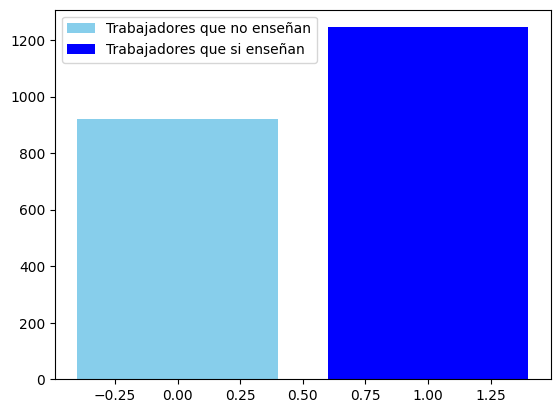

In [22]:
trabajadores_no_ensenan = np.setdiff1d(Trabajador.Trabajador.unique(), CargaLectivaZet.Trabajador.unique(), assume_unique=True)
fig, ax = plt.subplots()
ax.bar([0, 1], [trabajadores_no_ensenan.size, Trabajador.Trabajador.size - trabajadores_no_ensenan.size],
       label=['Trabajadores que no enseñan','Trabajadores que si enseñan'], color=['skyblue','blue'])
ax.legend()

In [23]:
# Eliminamos a los trabajadores que no enseñan, ya que solo nos interesa los docentes
Trabajador.drop(Trabajador[Trabajador.Trabajador.isin(trabajadores_no_ensenan)].index, inplace=True)
Trabajador.shape

(1245, 13)

In [24]:
Trabajador_Docentes = Trabajador.merge(Docentes, 'left', left_on='Trabajador', right_on='trabajador')
Trabajador_Docentes.Profesion.replace('', np.nan, inplace=True)
Trabajador_Docentes.Profesion.fillna(Trabajador_Docentes.titulo_profesional, inplace=True)
Trabajador_Docentes.drop(['trabajador','NombreCompleto_y','titulo_profesional'], axis=1, inplace=True)
Trabajador_Docentes.shape

(1245, 22)

In [25]:
# Numero de cursos programados que tienen a 2 docentes
grouped = CargaLectivaZet.groupby(index_columns)
carga_2_trabajadores = grouped.filter(lambda group: group['Trabajador'].nunique() == 2)
frac = carga_2_trabajadores.drop_duplicates(['Sede','Escuela','Curricula','Curso','Semestre','Seccion','Grupo']).sort_values('Curso').shape[0] / CargaLectivaZet.drop_duplicates(['Sede','Escuela','Curricula','Curso','Semestre','Seccion','Grupo']).sort_values('Curso').shape[0]
print(f'El {frac*100:.2f}% de los cursos programados tiene a 2 docentes simultaneos')

El 4.98% de los cursos programados tiene a 2 docentes simultaneos


In [26]:
merged = CursoProgramadoGrupo.merge(CargaLectivaZet.drop_duplicates(index_columns)[index_columns+['Trabajador']], how='left', on=index_columns)
merged.Trabajador_x.fillna(merged.Trabajador_y, inplace=True)
merged.drop('Trabajador_y', axis=1, inplace=True)
merged.sort_values(index_columns, inplace=True)
merged = merged.merge(CursoProgramado[index_columns[:-1]+['Trabajador']], 'left', index_columns[:-1])
merged.Trabajador_x.fillna(merged.Trabajador, inplace=True)
merged.drop('Trabajador', axis=1, inplace=True)
merged.dropna(axis=0, subset='Trabajador_x', inplace=True)
df = merged.copy()
df.drop(['CuentaCarga','Capacidad','modificable'], axis=1, inplace=True)
df = df.merge(Semestre[['Semestre','orden']], 'left', 'Semestre') 
df.orden = df.orden.astype('int')
df.sort_values(['Curso','orden','Seccion','Grupo','Curricula','Escuela'], inplace=True)
df = df.merge(Curso[['Escuela','Curricula','Curso','NumeroCreditos']], 'left', ['Escuela','Curricula','Curso'])
df.head()

,Sede,Escuela,Curricula,Curso,Semestre,Seccion,Grupo,Trabajador_x,Abreviatura,Nombre,NombreCompleto,orden,NumeroCreditos
0,01,04,04,040431,2010-1,1,1,NFR457,EST. E INFORMAT,CALCULO DE PROBABILIDADES,NaN,104,5.0
1,01,06,05,060511,2007-1,1,1,VJP178,ING. AMBIENTAL,INTRODUCCION A LA INGENIERIA AMBIENTAL,VALLADARES JARA PEDRO LIBERATO,95,3.0
2,01,06,05,060511,2007-1,1,2,VJP178,ING. AMBIENTAL,INTRODUCCION A LA INGENIERIA AMBIENTAL,VALLADARES JARA PEDRO LIBERATO,95,3.0
3,01,06,05,060511,2007-2,1,1,VJP178,ING. AMBIENTAL,INTRODUCCION A LA INGENIERIA AMBIENTAL,VALLADARES JARA PEDRO LIBERATO,96,3.0
4,01,06,05,060511,2008-1,1,1,RAR391,ING. AMBIENTAL,INTRODUCCION A LA INGENIERIA AMBIENTAL,RODRIGUEZ ANAYA ROSA DEIFILIA,98,3.0


In [27]:
orden = 139
trabajador_orden = df.groupby('Trabajador_x').agg(max_orden=('orden','max'))
trabajadores_inactivos = trabajador_orden[trabajador_orden.max_orden <= orden].index
Trabajador_Docentes.loc[Trabajador_Docentes.Trabajador.isin(trabajadores_inactivos), 'Activo'] = False

df_train, df_test = df[df.Semestre != '2022-2'].copy(), df[df.Semestre == '2022-2'].copy()
Trabajador_Docentes.loc[Trabajador_Docentes.Trabajador.isin(df_test.Trabajador_x.unique()), 'Activo'] = True
Trabajador_Docentes.drop(Trabajador_Docentes[Trabajador_Docentes.Activo == False].index, inplace=True)

df_train.shape, df_test.shape

((56992, 13), (1464, 13))

In [28]:
k = 0.05
x_0 = 90

df_train['rating'] = df_train.orden.apply(lambda x: logistic_function(x, k, x_0, 10))

grouped = df_train.groupby(['Curso','Trabajador_x'], as_index=False)
values = grouped.agg(rating = ('rating', 'sum'))
values.sort_values(['Curso','rating'], ascending=False, inplace=True)

def predecir_profesor(escuela, curricula, curso, semestre):
    if curso in values.Curso.values:
        return values[values.Curso == curso].iloc[0].Trabajador_x
    else:
        return 'ACD'

In [29]:
def get_score(k, x_0):
    df_train['rating'] = df_train.orden.apply(lambda x: logistic_function(x, k, x_0, 10))

    grouped = df_train.groupby(['Curso','Trabajador_x'], as_index=False)
    values = grouped.agg(rating = ('rating', 'sum'))
    values.sort_values(['Curso','rating'], ascending=False, inplace=True)

    semestre_2022_2 = df_test.loc[:, ['Escuela','Curricula','Curso','Semestre']]
    semestre_2022_2 = semestre_2022_2.merge(values.groupby('Curso').first()['Trabajador_x'], 'left', left_on='Curso', right_index=True)
    trabajadores_correctos = (df_test.Trabajador_x == semestre_2022_2.Trabajador_x).sum()
    total = df_test.shape[0]
    return trabajadores_correctos*100 / total

func = np.vectorize(get_score)

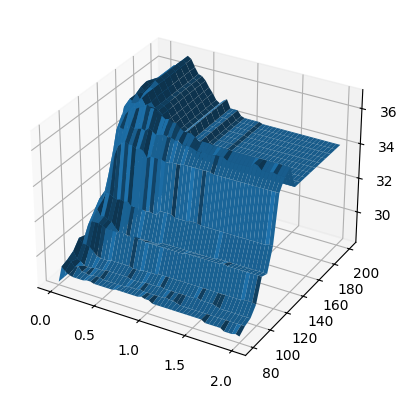

In [30]:
k_array = np.linspace(0, 2, num=50)
x_0_array = np.linspace(80, 200, num=20)
K, X_0 = np.meshgrid(k_array, x_0_array)
Z = func(K,X_0)
ax = plt.axes(projection='3d')
ax.plot_surface(K, X_0, Z)

In [31]:
indices = np.unravel_index(Z.argmax(), Z.shape)
best_k = K[indices]
best_x_0 = X_0[indices]
print(f'{best_k=} {best_x_0=}')

best_k=0.2857142857142857 best_x_0=162.10526315789474


In [32]:
df_train['rating'] = df_train.orden.apply(lambda x: logistic_function(x, best_k, best_x_0, 10))
grouped = df_train.groupby(['Curso','Trabajador_x'], as_index=False)
values = grouped.agg(rating = ('rating', 'sum'))
values.drop(values[values.Trabajador_x.isin(Trabajador_Docentes.loc[Trabajador_Docentes.Activo == False, 'Trabajador'])].index, inplace=True)
values.sort_values(['Curso','rating'], ascending=False, inplace=True)

semestre_2022_2 = df_test.loc[:, ['Escuela','Curricula','Curso','Semestre']].copy()
semestre_2022_2 = semestre_2022_2.merge(values.groupby('Curso').first()['Trabajador_x'], 'left', left_on='Curso', right_index=True)

trabajadores_correctos = (df_test.Trabajador_x == semestre_2022_2.Trabajador_x).sum()
total = df_test.shape[0]
trabajadores_correctos*100 / total

36.885245901639344

In [33]:
grouped = df_train.groupby(['Escuela','Trabajador_x'], as_index=False)
values_escuela = grouped.agg(rating = ('Escuela', 'count'))
values_escuela.sort_values(['Trabajador_x','rating'], inplace=True, ascending=False)
values_escuela = values_escuela.merge(values_escuela.groupby('Trabajador_x').rating.sum(), 'inner', left_on='Trabajador_x', right_index=True)
values_escuela.rating_x = values_escuela.rating_x / values_escuela.rating_y
values_escuela.drop('rating_y', axis=1, inplace=True)
values_escuela.head()

,Escuela,Trabajador_x,rating_x
6713,34,ZUG001,0.833333
4227,15,ZUG001,0.166667
7046,36,ZTLN65,0.900000
2702,09,ZTLN65,0.100000
1819,06,ZRV001,1.000000


In [34]:
def predecir_profesor(escuela, curricula, curso):
    if curso in values.Curso.values:
        return values[values.Curso == curso].iloc[0].Trabajador_x
    else:
        return 'ACD'

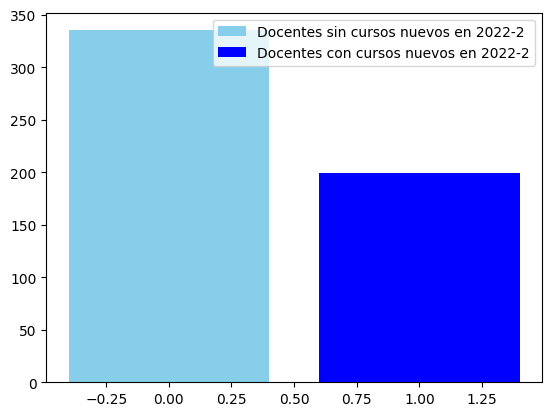

In [35]:
def trabajador_tiene_cursos_nuevos(trabajador):
    cursos_2022 = df_test[df_test.Trabajador_x == trabajador].Curso.unique()
    cursos_antiguos = df_train[df_train.Trabajador_x == trabajador].Curso.unique()
    cursos_nuevos = np.setdiff1d(cursos_2022, cursos_antiguos)
    return cursos_nuevos.size != 0

n_trabajadores_cursos_nuevos = np.vectorize(trabajador_tiene_cursos_nuevos)(df_test.Trabajador_x.unique()).sum()
fig, ax = plt.subplots()
ax.bar(x=[0,1], height=[df_test.Trabajador_x.unique().size-n_trabajadores_cursos_nuevos, n_trabajadores_cursos_nuevos], label=['Docentes sin cursos nuevos en 2022-2','Docentes con cursos nuevos en 2022-2'], color=['skyblue','blue'])
ax.legend()

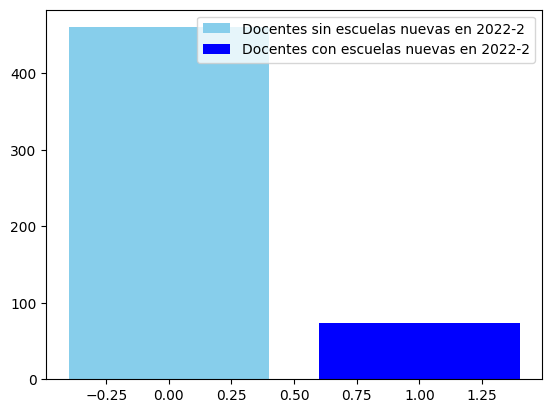

In [36]:
# Docentes que han enseñado en escuelas nuevas en el semestre 2022-2
def trabajador_tiene_escuelas_nuevas(trabajador):
    escuelas_2022 = df_test[df_test.Trabajador_x == trabajador].Escuela.unique()
    escuelas_antiguos = df_train[df_train.Trabajador_x == trabajador].Escuela.unique()
    escuelas_nuevos = np.setdiff1d(escuelas_2022, escuelas_antiguos)
    return escuelas_nuevos.size != 0

n_trabajadores_escuelas_nuevas = np.vectorize(trabajador_tiene_escuelas_nuevas)(df_test.Trabajador_x.unique()).sum()
fig, ax = plt.subplots()
ax.bar(x=[0,1], height=[df_test.Trabajador_x.unique().size-n_trabajadores_escuelas_nuevas, n_trabajadores_escuelas_nuevas], label=['Docentes sin escuelas nuevas en 2022-2','Docentes con escuelas nuevas en 2022-2'], color=['skyblue','blue'])
ax.legend()

In [37]:
def get_score(k, x_0):
    df_train['rating'] = df_train.orden.apply(lambda x: logistic_function(x, k, x_0, 100))

    values_both = df_train.groupby(['Escuela','Curso','Trabajador_x'], as_index=False).agg(rating = ('rating', 'sum'))
    values_both.sort_values(['Escuela','Curso','rating'], inplace=True, ascending=False)
    values_both = values_both[values_both.Trabajador_x.isin(Trabajador_Docentes.Trabajador)]

    semestre_2022_2 = df_test.loc[:, ['Escuela','Curricula','Curso','Semestre']].copy()
    semestre_2022_2 = semestre_2022_2.merge(values_both.groupby(['Escuela','Curso'])['Trabajador_x'].first(), 'left', left_on=['Escuela','Curso'], right_index=True)
    trabajadores_correctos = (df_test.Trabajador_x == semestre_2022_2.Trabajador_x).sum()
    total = df_test.shape[0]
    return trabajadores_correctos*100 / total

func = np.vectorize(get_score)

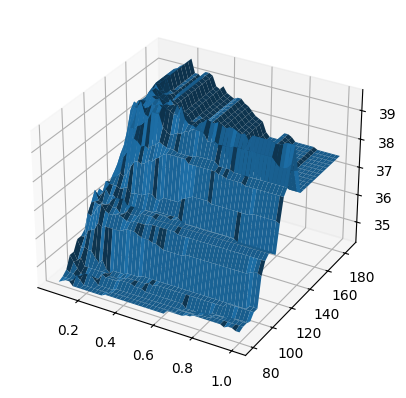

In [40]:
k_array = np.linspace(0.05, 1, num=50)
x_0_array = np.linspace(80, 185, num=30)
K, X_0 = np.meshgrid(k_array, x_0_array)
Z = func(K,X_0)
ax = plt.axes(projection='3d')
ax.plot_surface(K, X_0, Z)

In [41]:
indices = np.unravel_index(Z.argmax(), Z.shape)
best_k = K[indices]
best_x_0 = X_0[indices]
print(f'{best_k=} {best_x_0=}')

best_k=0.4183673469387755 best_x_0=134.31034482758622


In [42]:
df_train['rating'] = df_train.orden.apply(lambda x: logistic_function(x, best_k, best_x_0, 100))

values_both = df_train.groupby(['Escuela','Curso','Trabajador_x'], as_index=False).agg(rating = ('rating', 'sum'))
values_both.sort_values(['Escuela','Curso','rating'], inplace=True, ascending=False)
values_both = values_both[values_both.Trabajador_x.isin(Trabajador_Docentes.Trabajador)]

semestre_2022_2 = df_test.loc[:, ['Escuela','Curricula','Curso','Semestre']].copy()
semestre_2022_2 = semestre_2022_2.merge(values_both.groupby(['Escuela','Curso'])['Trabajador_x'].first(), 'left', left_on=['Escuela','Curso'], right_index=True)
trabajadores_correctos = (df_test.Trabajador_x == semestre_2022_2.Trabajador_x).sum()
total = df_test.shape[0]
print(f'Se ha predecido {trabajadores_correctos*100 / total:.2f}% de la carga academica correctamente')

Se ha predecido 39.62% de la carga academica correctamente


### COLLABORATIVE FILTERING

In [48]:
df

,Sede,Escuela,Curricula,Curso,Semestre,Seccion,Grupo,Trabajador_x,Abreviatura,Nombre,NombreCompleto,orden,NumeroCreditos,rating
0,01,04,04,040431,2010-1,1,1,NFR457,EST. E INFORMAT,CALCULO DE PROBABILIDADES,NaN,104,5.0,0.000311
1,01,06,05,060511,2007-1,1,1,VJP178,ING. AMBIENTAL,INTRODUCCION A LA INGENIERIA AMBIENTAL,VALLADARES JARA PEDRO LIBERATO,95,3.0,0.000007
2,01,06,05,060511,2007-1,1,2,VJP178,ING. AMBIENTAL,INTRODUCCION A LA INGENIERIA AMBIENTAL,VALLADARES JARA PEDRO LIBERATO,95,3.0,0.000007
3,01,06,05,060511,2007-2,1,1,VJP178,ING. AMBIENTAL,INTRODUCCION A LA INGENIERIA AMBIENTAL,VALLADARES JARA PEDRO LIBERATO,96,3.0,0.000011
4,01,06,05,060511,2008-1,1,1,RAR391,ING. AMBIENTAL,INTRODUCCION A LA INGENIERIA AMBIENTAL,RODRIGUEZ ANAYA ROSA DEIFILIA,98,3.0,0.000025
5,01,06,05,060511,2008-2,1,1,RAR391,ING. AMBIENTAL,INTRODUCCION A LA INGENIERIA AMBIENTAL,RODRIGUEZ ANAYA ROSA DEIFILIA,99,3.0,0.000038
6,01,06,05,060511,2009-1,1,1,RAR391,ING. AMBIENTAL,INTRODUCCION A LA INGENIERIA AMBIENTAL,RODRIGUEZ ANAYA ROSA DEIFILIA,101,3.0,0.000089
7,01,06,05,060511,2009-2,1,1,RAR391,ING. AMBIENTAL,INTRODUCCION A LA INGENIERIA AMBIENTAL,RODRIGUEZ ANAYA ROSA DEIFILIA,102,3.0,0.000135
8,01,06,05,060511,2010-1,1,1,RAR391,ING. AMBIENTAL,INTRODUCCION A LA INGENIERIA AMBIENTAL,RODRIGUEZ ANAYA ROSA DEIFILIA,104,3.0,0.000311
9,01,06,05,060511,2010-2,1,1,RAR391,ING. AMBIENTAL,INTRODUCCION A LA INGENIERIA AMBIENTAL,RODRIGUEZ ANAYA ROSA DEIFILIA,105,3.0,0.000473
